# **Age Trends Among Olympic Athletes**
## by David Kobilnyk
---


# Introduction

A friend of mine and I are fans of figure skating in the Winter Olympics. She made an observation that the ages and career lengths of competitive figure skaters have been decreasing over time, as the competition has gotten more fierce in recent years. I am curious to see how true the observation is within Olympic figure skating in particular, and within Olympic sports more generally. To this end, I found a data set on Kaggle that seems to be just what I need to figure this out: https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results/home.

The investigation will mostly focus on the ages of the athletes over time, and we will also look at many other variables to see if they help shed light on the age trends.

## Software installation versions
* python: 3.6.7
* numpy: 1.14.2
* scipy: 1.0.0
* scikit-learn: 0.19.1
* pandas: 0.23.4
* statsmodels: 0.9.0
* matplotlib: 3.0.2
* seaborn: 0.9.0

## Initial Setup

In [1]:
# Standard library
import itertools
import math
import random
import time


# Data science tools
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


# Pandas defaults.
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 30)


# Set up some chart defaults.
%matplotlib inline
plt.rcParams.update({'font.size': 14})
default_figwidth = 9
default_figheight = 9
default_figsize = (default_figwidth, default_figheight)
plt.figure(figsize=default_figsize);


# Some helpful chart functions.
def centered_bins_of_size_from_series(size, series):
    min_x, max_x = series.agg(['min', 'max']).tolist()
    bins = np.arange(min_x, max_x + size + 1, size) - (size / 2)
    return bins

def histogram_of_series_with_bin_size(series, size, figsize=default_figsize):
    bins = centered_bins_of_size_from_series(size, series)
    series.hist(bins=bins, figsize=figsize)

def barplot_of_top_n_of_series(n, series, figsize=default_figsize):
    (
        series
        .value_counts()
        .head(n)
        .sort_values()
        .plot(kind='barh', figsize=figsize, color='C0')
    )

def labels_title(xlabel, ylabel, title):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

def use_default_year_settings_for_x_axis(year_gap=12):
    plt.xlim(1895, 2017)
    year_ticks = range(1896, 2017, year_gap)
    plt.xticks(year_ticks, year_ticks)

def get_weights_for_norm_hist(df, groupby_col, percent=True):
    counts = df.groupby(groupby_col).count().iloc[:, 0].tolist()
    weights = np.array(list(itertools.chain(*[[1/n] * n for n in counts])))
    return weights * (100 if percent else 1)

# From https://stackoverflow.com/a/31302882/576101.
def weighted_hist(x, weights, **kwargs):
    plt.hist(x, weights=weights, **kwargs)

def repeat_facetgrid_ticklabels():
    # From https://stackoverflow.com/a/52184614/576101.
    for ax in g.axes.flatten():
        ax.tick_params(labelbottom=True, labelleft=True)


df_explore = pd.read_csv('df_explore.csv', index_col=0)
df_athletes_explore = pd.read_csv('df_athletes_explore.csv', index_col=0)
df_season_athletes_explore = (
    pd.read_csv('df_season_athletes_explore.csv', index_col=0)
)
df_season_athletes_explore.rename_axis('SeasonAthleteID', inplace=True)

df_explore_recent = df_explore[df_explore.Year >= 2014].copy()

Let's begin by taking another quick look at our tables.

In [2]:
df_athletes_explore.sample(3)

,Sex,BestMedal,NSeasons
AthleteID,,,
26694,M,None,1
113950,M,None,1
96267,M,None,1


In [3]:
df_season_athletes_explore.sample(3)

,AthleteID,Sex,Age,Country,Year,Season,NPreviousSeasons,IsFemale,SummerYear
SeasonAthleteID,,,,,,,,,
199176,132737,F,22,South Korea,2004,Summer,0,True,2004
9304,36944,M,27,Denmark,1912,Summer,0,False,1912
245528,87855,F,27,Canada,2016,Summer,0,True,2016


In [4]:
df_explore.sample(3)

,AthleteID,Sex,Age,Country,Year,Season,Sport,Event,Medal,NPreviousSeasons,IsTeamEvent,IsFemale,WonMedal,SummerYear,BestMedal,NSeasons
230679,118518,F,18,Singapore,2008,Summer,Swimming,Swimming Women's 200 metres Butterfly,None,0,False,True,False,2008,None,2
245293,27897,M,21,Italy,2016,Summer,Swimming,Swimming Men's 400 metres Freestyle,Bronze,1,False,False,True,2016,Bronze,2
23632,41900,M,32,Argentina,1936,Summer,Fencing,"Fencing Men's Foil, Individual",None,1,False,False,False,1936,None,2


We will consider the following variables in this section:
* `df_athletes_explore`: `Sex`, `BestMedal`, `NSeasons`
* `df_season_athletes_explore`: `Age`, `Country`, `Year`, `Season`
* `df_explore`: `Sport`, `Medal`, `IsTeamEvent`

Some of our exploration will consider athletes as primary and some will consider events as primary.

### Age

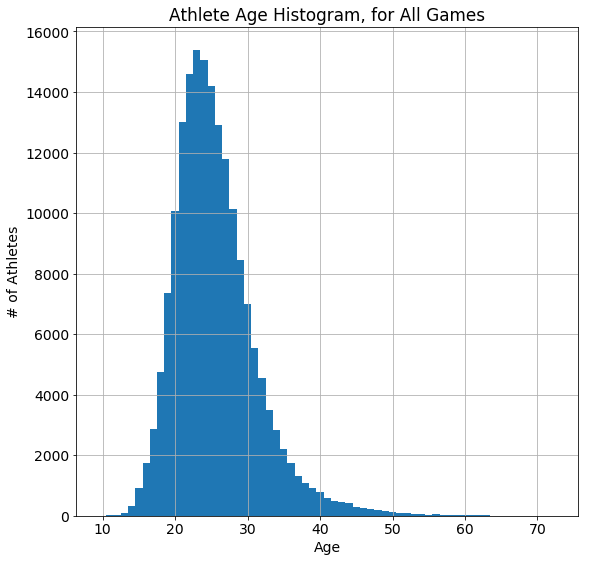

In [7]:
histogram_of_series_with_bin_size(df_season_athletes_explore.Age, 1)
labels_title('Age', '# of Athletes', 'Athlete Age Histogram, for All Games')

### NSeasons

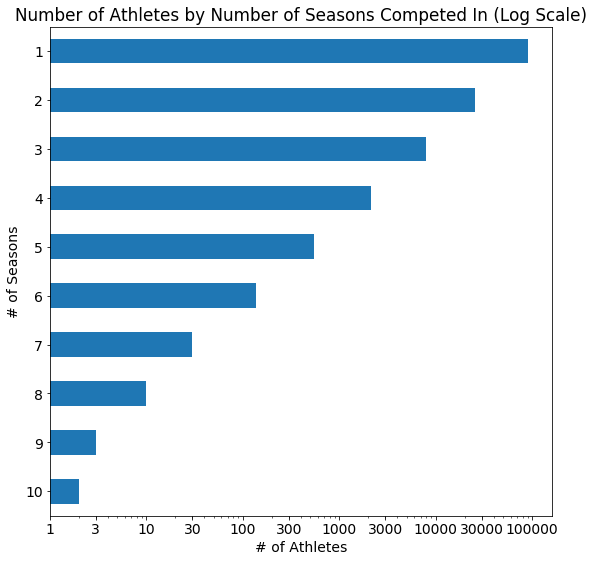

In [8]:
(
    df_athletes_explore
    .NSeasons
    .value_counts()
    .sort_values()
    .plot(kind='barh', color='C0', figsize=default_figsize, log=True)
)
labels_title(
    '# of Athletes', '# of Seasons',
    'Number of Athletes by Number of Seasons Competed In (Log Scale)'
)
xticks = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000]
plt.xticks(xticks, xticks);

The linearity of the log relationship here is striking.

### Year

A histogram of the `Year` variable results in a count of athletes over time. We will make our bins 4 years long -- usually this will give us one winter season and one summer season per bin.

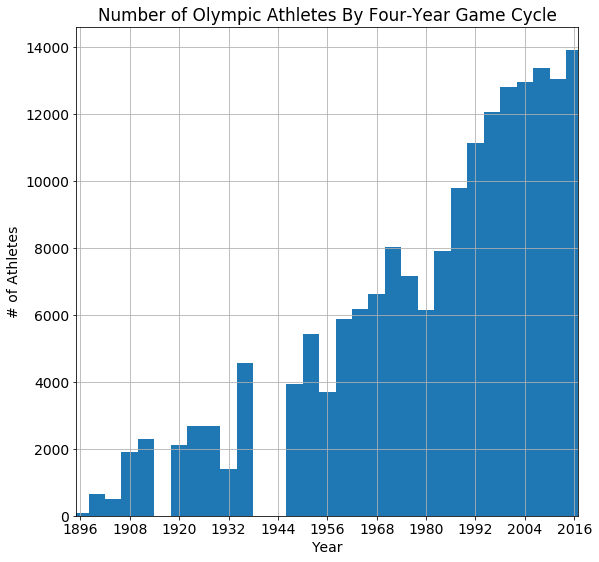

In [9]:
histogram_of_series_with_bin_size(df_season_athletes_explore.Year, 4)
labels_title(
    'Year', '# of Athletes',
    'Number of Olympic Athletes By Four-Year Game Cycle'
)

use_default_year_settings_for_x_axis()

No Olympic games occurred in 1916, 1940, or 1944, due to World Wars I and II. (See [Wikipedia](https://en.wikipedia.org/wiki/Olympic_Games#War_and_terrorism) for more info.)

### Sport

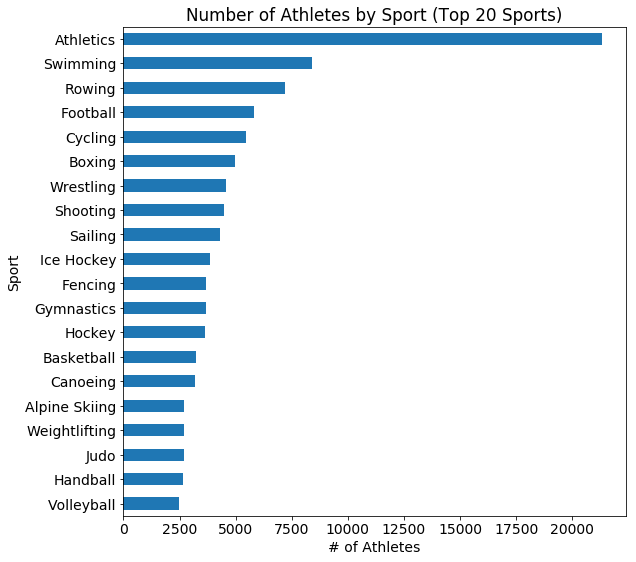

In [10]:
unique_athlete_sport_pairs = (
    df_explore[['AthleteID', 'Sport']].drop_duplicates().Sport)
barplot_of_top_n_of_series(20, unique_athlete_sport_pairs)
labels_title(
    '# of Athletes', 'Sport',
    'Number of Athletes by Sport (Top 20 Sports)'
)

Athletics dominates, with Ice Hockey taking the top spot for the Winter Olympics.

### Sex Ratio by Year

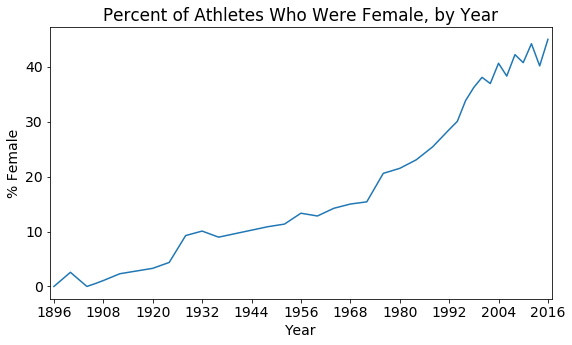

In [11]:
percent_female_by_year = (
    df_explore[['AthleteID', 'IsFemale', 'Year']]
    .groupby(['Year', 'AthleteID'])
    .max()
    .groupby('Year')
    .IsFemale
    .mean()
    * 100
)
plt.figure(figsize=(default_figwidth, 5))
plt.plot(percent_female_by_year.index, percent_female_by_year)
use_default_year_settings_for_x_axis()
labels_title(
    'Year', '% Female',
    'Percent of Athletes Who Were Female, by Year'
)

There was extreme marginalization of women in the early days of the Olympics; however, there has been a strong trend of increasing inclusion of women as athletes over time. Inclusion of women on the committee is another matter. (See https://en.wikipedia.org/wiki/Participation_of_women_in_the_Olympics.)

### NPreviousSeasons by Year

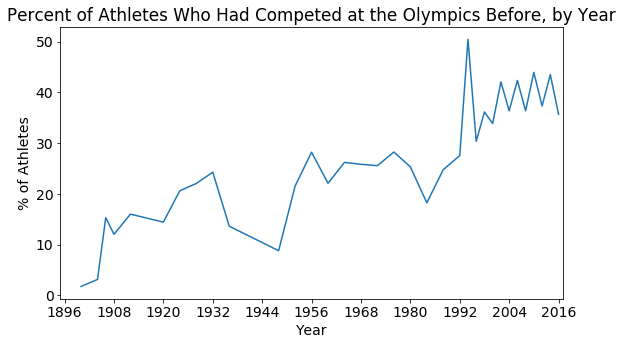

In [12]:
n_repeat_athletes_by_year = (
    (df_explore[['AthleteID', 'NPreviousSeasons', 'Year']]
    .groupby(['Year', 'AthleteID'])
    .max()
    .NPreviousSeasons > 0)
    .replace(False, np.NaN)
    .dropna()
    .to_frame()
    .reset_index()
    ['Year']
    .value_counts()
)
n_athletes_by_year = (
    df_explore[['AthleteID', 'Year']]
    .groupby(['Year', 'AthleteID'])
    .count()
    .reset_index()
    ['Year']
    .value_counts()
)
percent_repeat_athletes_by_year = (
    n_repeat_athletes_by_year / n_athletes_by_year * 100
)
plt.figure(figsize=(default_figwidth, 5))
plt.plot(percent_repeat_athletes_by_year)
use_default_year_settings_for_x_axis()
labels_title(
    'Year', '% of Athletes',
    'Percent of Athletes Who Had Competed at the Olympics Before, by Year'
)

There is a general trend toward increasingly more returning athletes which seems to have slowed or stalled over the past ~15 years.

### Age by Year

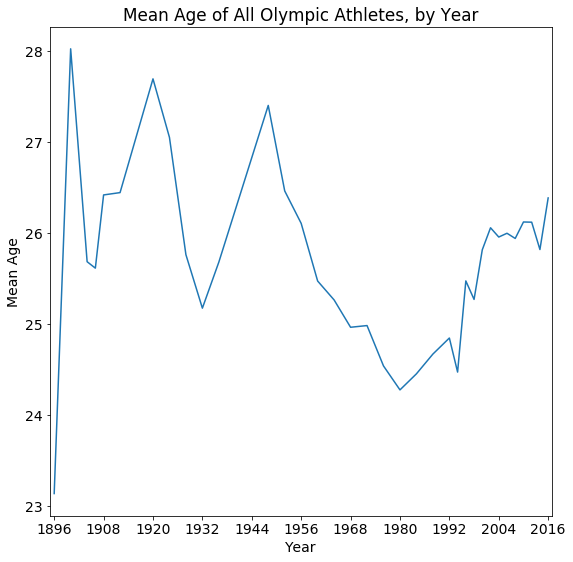

In [13]:
age_by_year = (
    df_explore
    .groupby(['AthleteID', 'Year'])
    .Age
    .mean()  # or min() or max(). The ages are the same for a given athlete.
    .to_frame()
    .reset_index()
    .groupby('Year')
    .Age
    .mean()
)
plt.figure(figsize=default_figsize)
plt.plot(age_by_year);
labels_title('Year', 'Mean Age', 'Mean Age of All Olympic Athletes, by Year')
use_default_year_settings_for_x_axis()

There is a lot of volatility in the early years. Recall that in the earlier years there were few athletes, and even fewer that we have ages for. Thus, our early data might not be as accurate. Even so, we will investigate a little bit there to see if we can gain any insight about the 5-year age jump from 1896 to 1900.

The two peaks at 1920 and 1948 coincide with post-war games. One could surmise that many athletes who had planned on competing in the canceled 1916, 1940, or 1944 games waited (and aged) until the next Olympics season, and that many younger would-be athletes were unable to practice for the Olympics during the harsh war years.

After the second Olympics, there is overall a large decrease in mean age until 1980.

The large increase from 1980 on may be caused by the increasing acceptance of professional athletes into the Olympics. See the following for more info on this topic:
* https://pc2018.com/amateurism-in-the-olympics/
* https://sports.vice.com/en_us/article/gvaqdm/for-love-or-for-money-a-history-of-amateurism-in-the-olympic-games
* https://www.uta.edu/english/sla/br170110.html

Interestingly, this age increase over the past ~30 years runs counter to the idea that athletes' ages are decreasing. Even so, it could be that the spread (i.e., standard deviation) of the ages is increasing and that people's memories hold onto the extreme cases of young athletes most. Let's test that idea by examining the standard deviation of the age over time, instead of the mean.

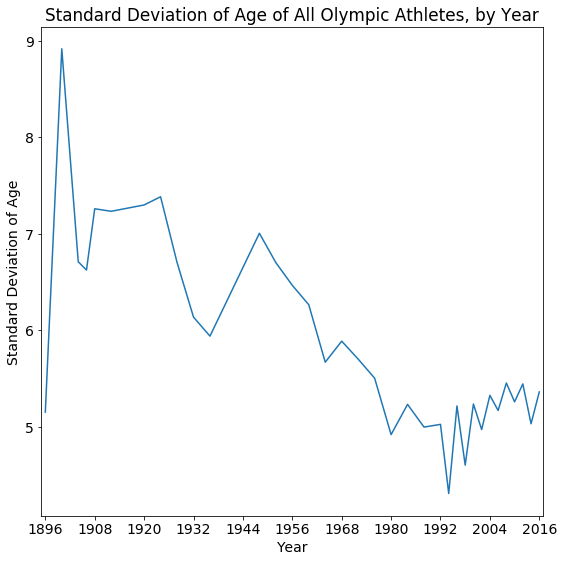

In [14]:
age_std_by_year = (
    df_explore
    .groupby(['AthleteID', 'Year'])
    .Age
    .mean()  # or min() or max(). The ages are the same for a given athlete.
    .to_frame()
    .reset_index()
    .groupby('Year')
    .Age
    .std()
)
plt.figure(figsize=default_figsize)
plt.plot(age_std_by_year);
labels_title(
    'Year', 'Standard Deviation of Age',
    'Standard Deviation of Age of All Olympic Athletes, by Year')
use_default_year_settings_for_x_axis()

There is a small increase in the standard deviation for the last ~20 years. 

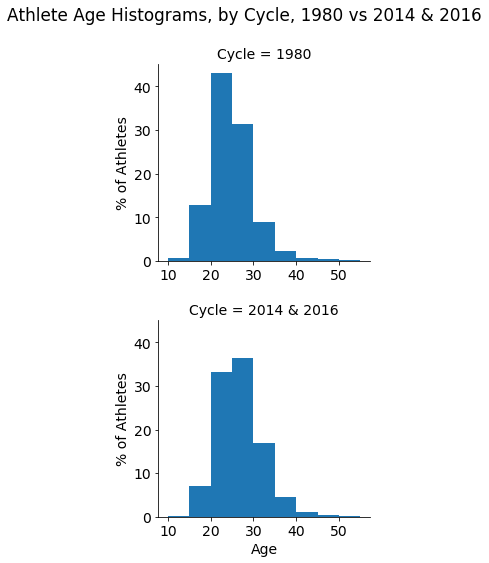

In [15]:
df_season_athletes_limited = (
    df_season_athletes_explore
    [
        (df_season_athletes_explore.Year == 1980) |
        (df_season_athletes_explore.Year >= 2014)
    ].copy()
)
# Used https://stackoverflow.com/a/45037219/576101.
df_season_athletes_limited['Cycle'] = (
    np.where(df_season_athletes_limited.Year >= 2014, '2014 & 2016', '1980'))
df_season_athletes_limited = df_season_athletes_limited.sort_values('Cycle')
df_season_athletes_limited['% of Athletes'] = (
    get_weights_for_norm_hist(df_season_athletes_limited, 'Cycle')
)

g = sns.FacetGrid(df_season_athletes_limited, row='Cycle', height=4)
g.map(weighted_hist, 'Age', '% of Athletes', bins=range(10, 56, 5))
g.fig.subplots_adjust(top=0.88, hspace=0.3)
g.fig.suptitle('Athlete Age Histograms, by Cycle, 1980 vs 2014 & 2016');
xticks = range(10, 56, 10)
plt.xticks(xticks, xticks);

repeat_facetgrid_ticklabels()

There is not any shift to younger athletes here either. Of course, there are many other factors that could be at play as well: for example, the age trend for Figure Skating might be different than the general trend, or the age trend for medalists might be different than non-medalists, or some kind of shift to younger athletes in the distribution might have occurred more recently than the 1980. We will explore such issues in the Multivariate section later.

Now let's back up and check on that huge difference in mean age (5 years) from 1896 to 1900. Perhaps it has something to do with the particular sports offered?

In [16]:
sports_1896 = set(df_explore[df_explore.Year == 1896].Sport.unique())
print(sports_1896)

{'Tennis', 'Weightlifting', 'Shooting', 'Wrestling', 'Swimming', 'Athletics', 'Cycling', 'Fencing', 'Gymnastics'}


In [17]:
sports_1900 = set(df_explore[df_explore.Year == 1900].Sport.unique())
print(sports_1900)

{'Tennis', 'Cricket', 'Polo', 'Croquet', 'Tug-Of-War', 'Sailing', 'Shooting', 'Swimming', 'Water Polo', 'Athletics', 'Equestrianism', 'Basque Pelota', 'Rugby', 'Cycling', 'Fencing', 'Rowing', 'Gymnastics', 'Football', 'Golf'}


Indeed, many more sports were added in 1900. Perhaps the mean ages of these sports tend to be higher. We will explore the mean ages of various sports in a later section. Let's see which sports remained constant for both Olympic years.

In [18]:
sports_1896_1900 = sports_1896.intersection(sports_1900)
sports_1896_1900

{'Athletics',
 'Cycling',
 'Fencing',
 'Gymnastics',
 'Shooting',
 'Swimming',
 'Tennis'}

Quite a few. Let's see what the mean age is for all of these sports for 1896 and also for 1900.

In [19]:
df_explore[
    (df_explore.Year.isin([1896, 1900])) &
    (df_explore.Sport.isin(sports_1896_1900))
].groupby('Year').Age.mean()

Year
1896    23.625000
1900    27.658466
Name: Age, dtype: float64

Well, that hypothesis didn't hold. The age jump for all of the sports from 1896 to 1900 was about 5 years, and this is still 4. So, indeed, the change in sports might account for some of the age change but not much of it. Perhaps the countries participating changed?

In [20]:
countries_1896 = set(df_explore[df_explore.Year == 1896].Country.unique())
print(countries_1896)

{'Sweden', 'Australia', 'USA', 'Germany', 'Hungary', 'France', 'Switzerland', 'Denmark', 'Austria', 'UK', 'Greece'}


In [21]:
countries_1900 = set(df_explore[df_explore.Year == 1900].Country.unique())
print(countries_1900)

{'Belgium', 'Germany', 'Brazil', 'Peru', 'Norway', 'Canada', 'Greece', 'India', 'Australia', 'Hungary', 'France', 'Italy', 'Netherlands', 'UK', 'Luxembourg', 'Spain', 'Sweden', 'Argentina', 'Denmark', 'Austria', 'Haiti', 'Czech Republic', 'Russia', 'Colombia', 'USA', 'Switzerland', 'Mexico', 'Cuba', 'New Zealand', 'Romania'}


Indeed, many more countries in 1900 than in 1896. Let's see how mean age compares for the same countries from 1896 to 1900.

In [22]:
countries_1896_1900 = countries_1896.intersection(countries_1900)
print(countries_1896_1900)

{'Sweden', 'Australia', 'USA', 'Germany', 'Hungary', 'France', 'Switzerland', 'Denmark', 'Austria', 'UK', 'Greece'}


Looks like every country that participated in 1896 also participated in 1900.

In [23]:
df_explore[
    (df_explore.Year.isin([1896, 1900])) &
    (df_explore.Sport.isin(sports_1896_1900)) &
    (df_explore.Country.isin(countries_1896_1900))
].groupby('Year').Age.mean()

Year
1896    23.625000
1900    27.093972
Name: Age, dtype: float64

Well, we are down just slightly more in the age gap. Let's leave out returning athletes.

In [24]:
df_explore[
    (df_explore.Year.isin([1896, 1900])) &
    (df_explore.Sport.isin(sports_1896_1900)) &
    (df_explore.Country.isin(countries_1896_1900)) &
    (df_explore.NPreviousSeasons == 0)
].groupby('Year').Age.mean()

Year
1896    23.625000
1900    27.114754
Name: Age, dtype: float64

This result is certainly counterintuitive. The mean age of the new athletes was about the same, even just a hair older than the returning athletes. Something seems to be dramatically different about the 1900 Olympics vs the 1896 Olympics. At this point, it seems reasonable to do some qualitative investigation online about the 1900 Olympics. What was so unusual about them?

Ah, well, here is an interesting piece of information:
"The Games of 1900 were held in Paris as part of the World's Fair. The organisers spread the competitions over five months and under-promoted their Olympic status to such an extent that many athletes never knew they had actually participated in the Olympic Games." (https://www.olympic.org/paris-1900)

So, we could imagine then that the World's Fair may have attracted older individuals than the Olympics themselves tend to attract, so that the year 1900 should be treated as an anomaly.

That still doesn't explain why subsequent years still had so much higher mean ages than 1896. Let's check on 1904.

Indeed, the World's Fair also coincided with the 1904 Olympics as well: "Unfortunately, the St Louis Games repeated all of the mistakes of 1900. The various competitions were spread out over four-and-a-half months and became lost in the chaos of a World’s Fair celebrating the purchase of the Louisiana territory from France." (https://www.olympic.org/st-louis-1904)

It appears that the 1906 Olympics were conducted more in line with how we'd expect (https://en.wikipedia.org/wiki/1906_Intercalated_Games). Let's compare 1896 and 1906, and get a little more exact in our comparison.

In [25]:
def intersection_of_events_in_years(df, year1, year2):
    events1 = set(df_explore[df_explore.Year == year1].Event.unique())
    events2 = set(df_explore[df_explore.Year == year2].Event.unique())
    return events1.intersection(events2)

def intersection_of_countries_in_years(df, year1, year2):
    countries1 = set(df_explore[df_explore.Year == year1].Country.unique())
    countries2 = set(df_explore[df_explore.Year == year2].Country.unique())
    return countries1.intersection(countries2)

events = intersection_of_events_in_years(df_explore, 1896, 1906)
countries = intersection_of_countries_in_years(df_explore, 1896, 1906)

df_explore[
    (df_explore.Year.isin([1896, 1906])) &
    (df_explore.Event.isin(events)) &
    (df_explore.Country.isin(countries)) &
    (df_explore.NPreviousSeasons == 0) &
    (df_explore.Sex == 'M')
].groupby('Year').Age.mean()

Year
1896    22.171171
1906    24.121359
Name: Age, dtype: float64

We still have a gap of about 2 years. Well, that doesn't seem quite as surprising. And we still have to remember that we are missing a fair amount of age data from this time period. In any case, there was a significant increase in the mean age of athletes after the first Olympiad. It is not clear why the participants in the first Olympiad were so young.

## Multivariate
[<a href="#Table-of-Contents">Back to Table of Contents</a>]

In [26]:
df_explore.head(3)

,AthleteID,Sex,Age,Country,Year,Season,Sport,Event,Medal,NPreviousSeasons,IsTeamEvent,IsFemale,WonMedal,SummerYear,BestMedal,NSeasons
0,35698,M,22,Australia,1896,Summer,Athletics,Athletics Men's 800 metres,Gold,0,False,False,True,1896,Gold,1
1,35698,M,22,Australia,1896,Summer,Athletics,"Athletics Men's 1,500 metres",Gold,0,False,False,True,1896,Gold,1
2,35698,M,22,Australia,1896,Summer,Athletics,Athletics Men's Marathon,None,0,False,False,False,1896,Gold,1


We will examine the following variable combinations:
* `Age`, `Sex`, `Medal`
* `Age`, `Year`, `Sex`
* `Age`, `Year`, `Country`
* `Age`, `Year`, `Season`
* `Age`, `Year`, `Sport`
* `Age`, `Year`, `Medal`
* `Age`, `Year`, `Sex`, `Medal`
* `Age`, `Year`, `Sex`, `Country`
* `Age`, `Year`, `Sex`, `Sport`

### Age, Year, Sex, Medal

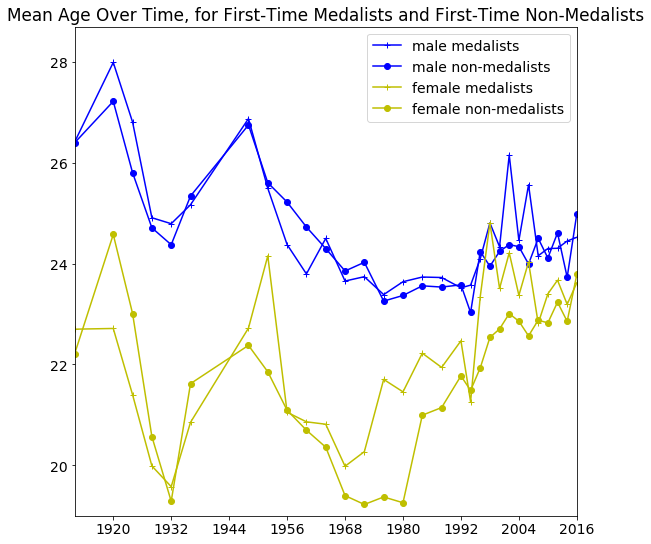

In [27]:
df_age_by_year_medal = (
    df_explore[(df_explore.NPreviousSeasons == 0)]
    .groupby(['Year', 'Sex', 'WonMedal']).Age.mean().to_frame().reset_index()
)
plt.figure(figsize=default_figsize)
male = df_age_by_year_medal.Sex == 'M'
won_medal = df_age_by_year_medal.WonMedal

plt.plot(df_age_by_year_medal[male & won_medal].copy()[['Year', 'Age']].set_index('Year'), marker='+', color='b', label='male medalists')

plt.plot(df_age_by_year_medal[male & ~won_medal].copy()[['Year', 'Age']].set_index('Year'), marker='o', color='b', label='male non-medalists')

plt.plot(df_age_by_year_medal[~male & won_medal].copy()[['Year', 'Age']].set_index('Year'), marker='+', color='y', label='female medalists')
plt.plot(df_age_by_year_medal[~male & ~won_medal].copy()[['Year', 'Age']].set_index('Year'), marker='o', color='y', label='female non-medalists')


plt.title(
    'Mean Age Over Time, for First-Time Medalists and First-Time Non-Medalists'
)
use_default_year_settings_for_x_axis()
plt.xlim(1912, 2016)
plt.ylim(19, 28.7);
plt.legend();

There is a huge jump in female medalist age from 1994 to 1998.

### Age, Year, Sex, Sport

Since female participation was meager in the early days, let's only use sports that have had female participation for a long time for this comparison.

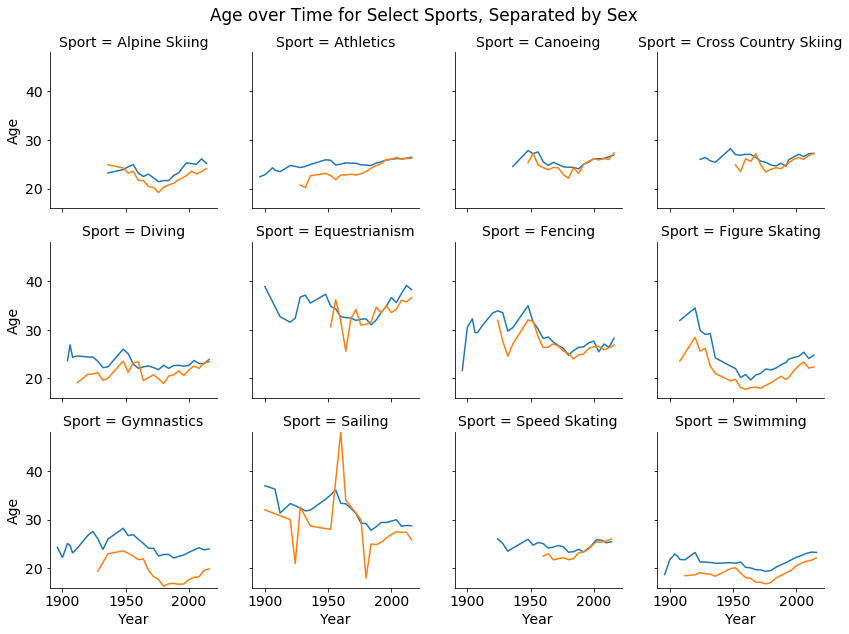

In [28]:
n_female_years_per_sport = (
    df_explore[df_explore.IsFemale]
    .groupby(['Sport', 'Year'])
    .AthleteID.count().to_frame().reset_index()
    .groupby('Sport').Year.count().sort_values()
)
most_freq_f_sports = sorted(n_female_years_per_sport.tail(12).index.tolist())

age_by_year_sport_sex = (
    df_explore
    [df_explore.Sport.isin(most_freq_f_sports)]
    .groupby(['Year', 'Sport', 'Sex'])
    .Age
    .mean()
    .to_frame()
    .reset_index()
)
g = sns.FacetGrid(
    data=age_by_year_sport_sex,
    hue='Sex',
    hue_order=['M', 'F'],
    col='Sport',
    col_wrap=4,
    col_order=most_freq_f_sports
)
plt.ylim(16, 48)
g.map(plt.plot, 'Year', 'Age');
g.fig.subplots_adjust(top=0.91)
g.fig.suptitle('Age over Time for Select Sports, Separated by Sex');

Some observations:
* Athletics has a relatively stable linear change over time.
* Almost all of them have increasing age during the last ~25 years.
* Figure Skating has a very pronounced U shape.

We can spot the familiar pattern in many of these sports of women's narrowing or closing the age gap with the men. Not so much with Gymnastics, however. It is interesting that Figure Skating maintains a consistent age gap between males and females, whereas Speed Skating appears to have closed it completely.

### Retirement Age by Year

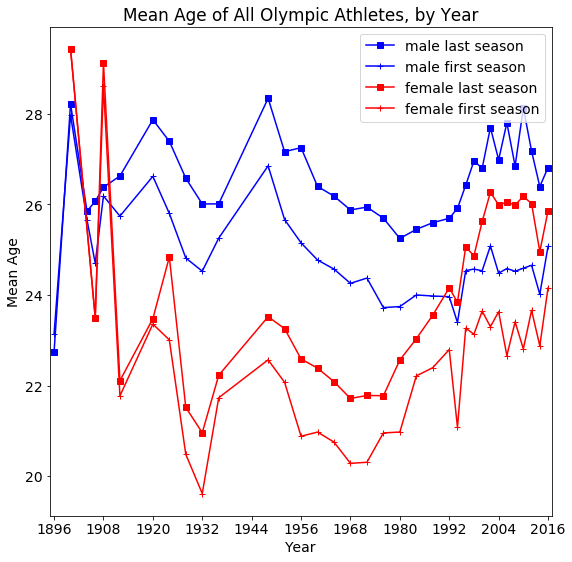

In [29]:
df_explore_male = df_explore[~df_explore.IsFemale]
df_explore_female = df_explore[df_explore.IsFemale]

male_age_by_year = (
    df_explore_male
    .groupby(['AthleteID', 'Year'])
    .Age
    .mean()  # or min() or max(). The ages are the same for a given athlete.
    .to_frame()
    .reset_index()
    .groupby('Year')
    .Age
    .mean()
)
# is_retiring = (df_explore_female.NSeasons == df_explore_female.NPreviousSeasons + 1)
male_retirees_by_year = (
    df_explore_male[
        (df_explore_male.NSeasons == df_explore_male.NPreviousSeasons + 1) 
#         &
#         (df_explore_male.NSeasons > 1)
    ]
    .groupby(['AthleteID', 'Year'])
    .Age
    .mean()  # or min() or max(). The ages are the same for a given athlete.
    .to_frame()
    .reset_index()
    .groupby('Year')
    .Age
    .mean()
)
male_new_by_year = (
    df_explore_male[
        (df_explore_male.NPreviousSeasons == 0)
#         &
#         (df_explore_male.NSeasons > 1)
    ]
    .groupby(['AthleteID', 'Year'])
    .Age
    .mean()  # or min() or max(). The ages are the same for a given athlete.
    .to_frame()
    .reset_index()
    .groupby('Year')
    .Age
    .mean()
)
male_onetimer_by_year = (
    df_explore_male[
        (df_explore_male.NPreviousSeasons == 0) &
        (df_explore_male.NSeasons == 1)
    ]
    .groupby(['AthleteID', 'Year'])
    .Age
    .mean()  # or min() or max(). The ages are the same for a given athlete.
    .to_frame()
    .reset_index()
    .groupby('Year')
    .Age
    .mean()
)

plt.figure(figsize=default_figsize)
# plt.plot(age_by_year);
plt.plot(male_retirees_by_year, color='b', label='male last season', marker='s');
plt.plot(male_new_by_year, color='b', label='male first season', marker='+');
# plt.plot(male_onetimer_by_year, color='k', label='male one-timer', marker='o');



female_age_by_year = (
    df_explore_female
    .groupby(['AthleteID', 'Year'])
    .Age
    .mean()  # or min() or max(). The ages are the same for a given athlete.
    .to_frame()
    .reset_index()
    .groupby('Year')
    .Age
    .mean()
)
# is_retiring = (df_explore_female.NSeasons == df_explore_female.NPreviousSeasons + 1)
female_retirees_by_year = (
    df_explore_female[
        (df_explore_female.NSeasons == df_explore_female.NPreviousSeasons + 1)
#         &
#         (df_explore_female.NSeasons > 1)
    ]
    .groupby(['AthleteID', 'Year'])
    .Age
    .mean()  # or min() or max(). The ages are the same for a given athlete.
    .to_frame()
    .reset_index()
    .groupby('Year')
    .Age
    .mean()
)
female_new_by_year = (
    df_explore_female[
        (df_explore_female.NPreviousSeasons == 0)
#         &
#         (df_explore_female.NSeasons > 1)
    ]
    .groupby(['AthleteID', 'Year'])
    .Age
    .mean()  # or min() or max(). The ages are the same for a given athlete.
    .to_frame()
    .reset_index()
    .groupby('Year')
    .Age
    .mean()
)
female_onetimer_by_year = (
    df_explore_female[
        (df_explore_female.NPreviousSeasons == 0) &
        (df_explore_female.NSeasons == 1)
    ]
    .groupby(['AthleteID', 'Year'])
    .Age
    .mean()  # or min() or max(). The ages are the same for a given athlete.
    .to_frame()
    .reset_index()
    .groupby('Year')
    .Age
    .mean()
)

# plt.figure(figsize=default_figsize)
# plt.plot(age_by_year);
plt.plot(female_retirees_by_year, color='r', label='female last season', marker='s');
plt.plot(female_new_by_year, color='r', label='female first season', marker='+');
# plt.plot(female_onetimer_by_year, color='b', label='female one-timer', marker='o');
plt.legend()

labels_title('Year', 'Mean Age', 'Mean Age of All Olympic Athletes, by Year')
use_default_year_settings_for_x_axis()


# plt.figure(figsize=default_figsize)
# plt.plot(maxage_by_year);
# labels_title('Year', 'Mean Age', 'Mean Age of All Olympic Athletes, by Year')
# use_default_year_settings_for_x_axis()